In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.couzin_utils import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from marl_aquarium import aquarium_v0
from models.Buffer import Pool, Buffer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
gail_folder = "GAIL Training - 30.11.2025_18.09 - Video Data"
bc_folder = "BC Training - 19.11.2025_18.52 - Couzin Data"

model_folder = rf"..\data\2. Training\training"
gail_path = os.path.join(model_folder, "GAIL", gail_folder)
bc_path = os.path.join(model_folder, "BC", bc_folder)

expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Comparison using Swarm Metrics

In [3]:
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)

env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
print("Environment initialized")

Environment initialized


In [ ]:
num_steps = 100

# GAIL Simulation
gail_pred_policy = torch.load(os.path.join(gail_path, "gail_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "gail_prey_policy.pt"), weights_only=False)
gail_metrics = run_policies_in_steps(env, gail_pred_policy, gail_prey_policy, steps=num_steps, render=False)
print("GAIL Simulation done!")

# BC Simulation
bc_pred_policy = torch.load(os.path.join(bc_path, "bc_pred_policy.pt"), weights_only=False)
bc_prey_policy = torch.load(os.path.join(bc_path, "bc_prey_policy.pt"), weights_only=False)
bc_metrics = run_policies_in_steps(env, bc_pred_policy, bc_prey_policy, steps=num_steps, render=False)
print("BC Simulation done!")

# Couzin Simulation
couzin_pred_tensor, couzin_prey_tensor, couzin_metrics = run_couzin_simulation(visualization="off", max_steps=num_steps)
print("Couzin Simulation done!")

# Load Expert Data
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)
print("Expert Metrics computed!")

GAIL Simulation done!


AttributeError: Can't get attribute 'PredatorAttention' on <module 'models.ModularNetworks' from 'c:\\Users\\janni\\OneDrive\\Dokumente\\Privat\\Bildung\\M. Sc. Social and Economic Data Science\\4. Semester\\Master Thesis\\Code\\notebooks\\models\\ModularNetworks.py'>

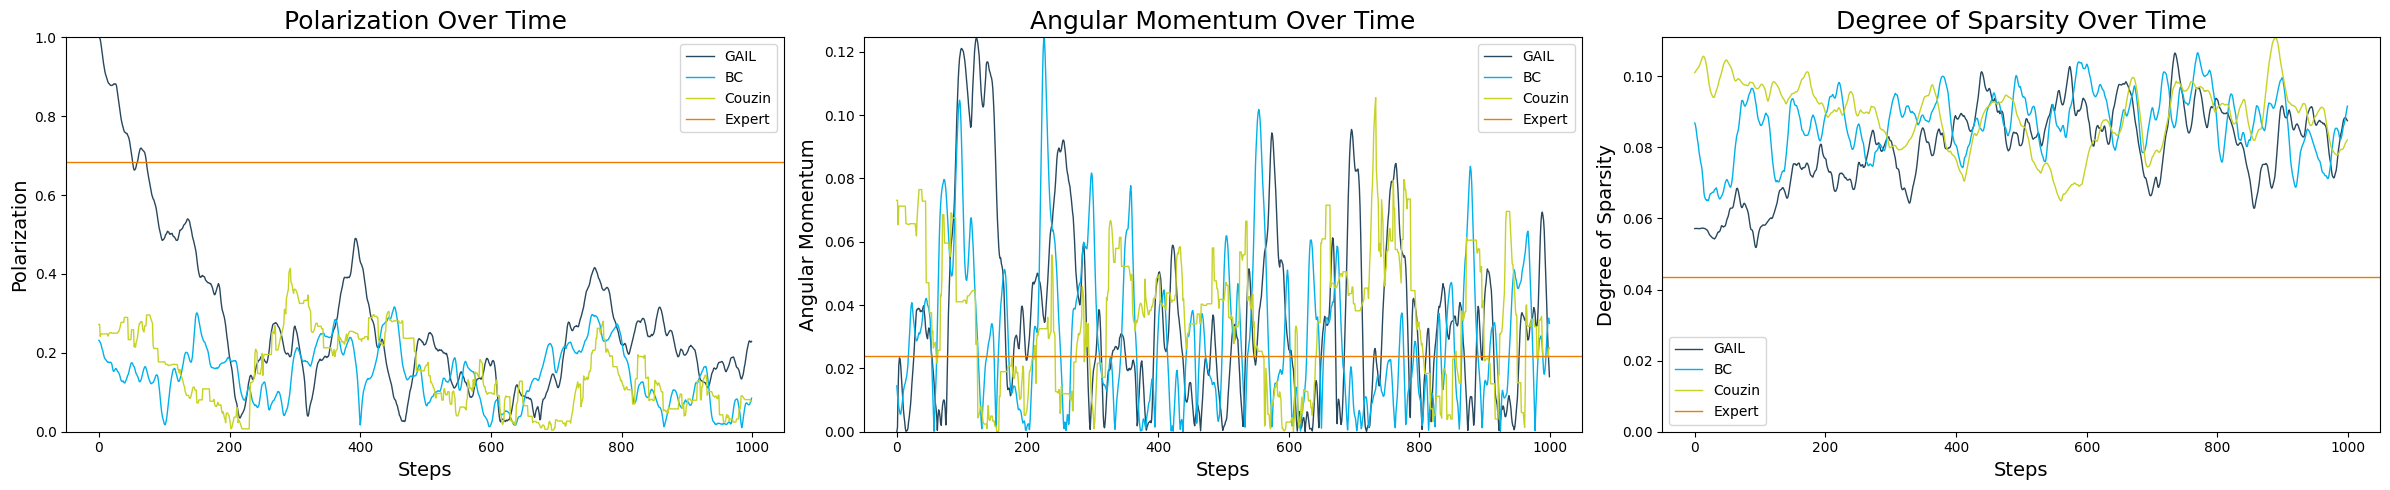

In [ ]:
plot_swarm_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics)

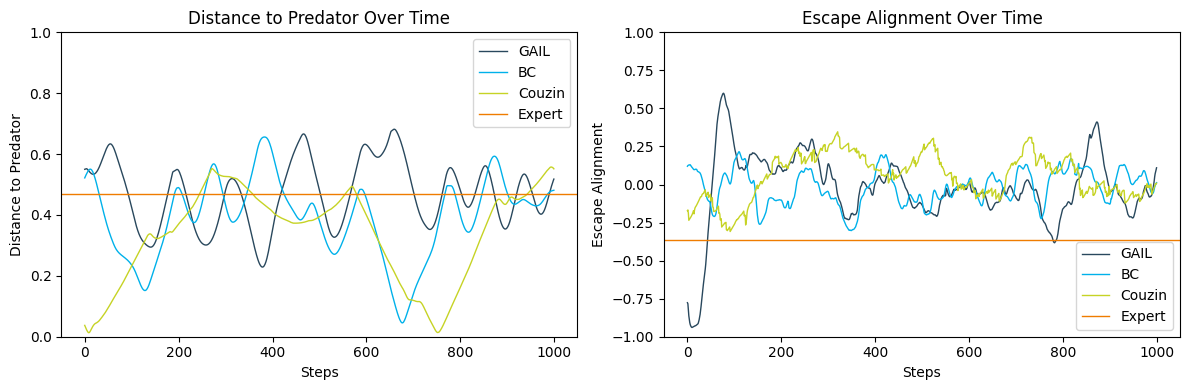

In [ ]:
plot_pred_prey_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics)

In [ ]:
"""
Plot trajectory function einbauen

"""

## Analysis of Modular Networks

In [3]:
gail_pred_policy = torch.load(os.path.join(gail_path, "gail_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "gail_prey_policy.pt"), weights_only=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

In [50]:
def compute_pin_an_maps(pin, an, grid_size=100, n_orient=72):

    pin.to("cpu").eval()
    an.to("cpu").eval()

    xs = np.linspace(-1, 1, grid_size)
    ys = np.linspace(-1, 1, grid_size)

    thetas = torch.linspace(-np.pi, np.pi, n_orient+1, device="cpu")[:-1]
    rel_vx = 1 * torch.cos(thetas)
    rel_vy = 1 * torch.sin(thetas)

    action_map = np.zeros((grid_size, grid_size), dtype=np.float32)
    attn_map = np.zeros((grid_size, grid_size), dtype=np.float32)

    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            dx = torch.full((n_orient, 1), float(x), device="cpu")
            dy = torch.full((n_orient, 1), float(y), device="cpu")
            inputs = torch.cat([dx, dy, rel_vx.unsqueeze(1), rel_vy.unsqueeze(1)], dim=1)

            # PIN: mu, sigma
            mu, sigma = pin(inputs)
            turn = torch.tanh(mu.squeeze())
            action_map[iy, ix] = turn.mean().item()

            # AN: attention logits/weights
            w_logits = an(inputs)
            w_logits = w_logits[0].squeeze()
            attn_map[iy, ix] = w_logits.mean().item()

    return xs, ys, action_map, attn_map



def plot_policy_maps(xs, ys, action_map, attn_map, role="predator", img_path=None):

    cmap_pin_color = "inferno"
    cmap_an_color = "RdBu"
    x, y = np.meshgrid(xs, ys)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ----- Pairwise-Interaction Map -----
    scaled_action_map = action_map * 180
    vmax_act = np.nanmax(np.abs(scaled_action_map))
    norm_act = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_act, vmax=vmax_act)

    im0 = axes[0].contourf(x, y, scaled_action_map, levels=30, cmap=cmap_pin_color, norm=norm_act)
    axes[0].set_title(f"[{role.upper()}] Pairwise-Interaction Map")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    plt.colorbar(im0, ax=axes[0], label="action")

    # ----- Attention Map -----
    vmax_att = np.nanmax(np.abs(attn_map))
    norm_att = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_att, vmax=vmax_att)

    im1 = axes[1].contourf(x, y, attn_map, levels=30, cmap=cmap_an_color, norm=norm_att)
    axes[1].set_title(f"[{role.upper()}] Attention Map")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    plt.colorbar(im1, ax=axes[1], label="attention (logit)")

    x_range = (xs.min(), xs.max())
    y_range = (ys.min(), ys.max())
    for ax in axes:
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

    if img_path is not None and os.path.exists(img_path):
        icon = mpimg.imread(img_path)
        imgbox = OffsetImage(icon, zoom=0.45)
        center = (0, 0)
        for ax in axes:
            ab = AnnotationBbox(imgbox, center, frameon=False, xycoords='data')
            ax.add_artist(ab)

    plt.tight_layout()
    plt.show()


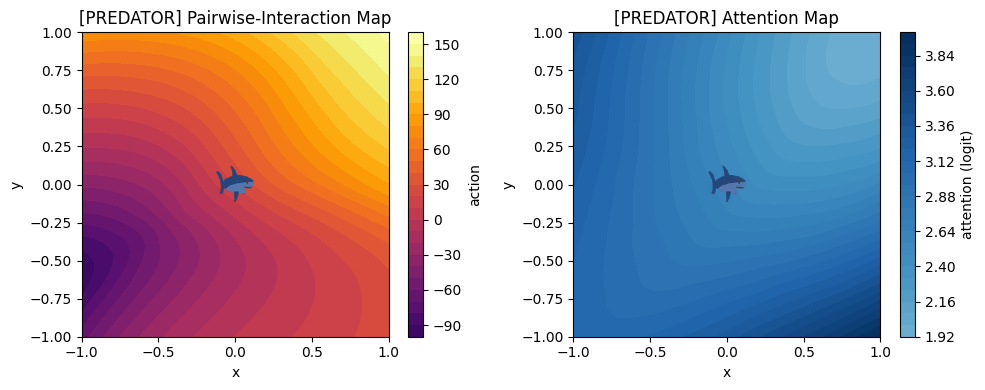

In [51]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(pin=gail_pred_policy.pairwise, an=gail_pred_policy.attention)

plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

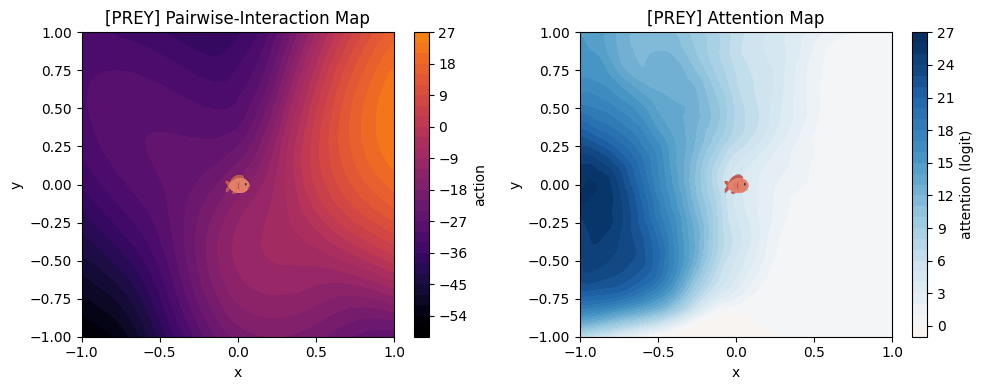

In [52]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin = gail_prey_policy.prey_pairwise, an = gail_prey_policy.prey_attention)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)